In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import os
font = {#'family' : 'normal',
        #'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

initial_pool_size = {
    "Splice": 2,
    "SpliceEncoded": 2,
    "DNA": 3,
    "DNAEncoded": 3,
    "USPS": 10,
    "USPSEncoded": 10,
    "Cifar10": 1000,
    "Cifar10Encoded":10,
    "FashionMnist": 1000,
    "FashionMnistEncoded": 10,
    "TopV2": 7,
    "News": 15
}

def get_init_pool_size(dataset_agent:str):
    dataset, _ = dataset_agent.split("/")
    return initial_pool_size.get(dataset, 0)


def moving_avrg(curve, weight):
    stdCurve = curve[1]
    curve = curve[0]
    avrg_mean = []
    avrg_std = []
    moving_mean = curve[0]
    moving_std = stdCurve[0]
    for i in range(1, len(curve)):
        moving_mean = weight * moving_mean + (1 - weight) * curve[i]
        moving_std = weight * moving_std + (1 - weight) * stdCurve[i]
        avrg_mean.append(moving_mean)
        avrg_std.append(moving_std)
    return np.array(avrg_mean), np.array(avrg_std)

def plot_upper_bound(dataset, budget, color, alpha=0.8, percentile=0.98, linewidth=2, run_name="UpperBound"):
    file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", dataset, f"{run_name}/accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    # mean = np.mean(all_runs.values, axis=1)
    mean = np.median(all_runs.values, axis=1)
    mean_percentile = percentile * mean
    mean = [float(mean)]*budget
    mean_percentile = [float(mean_percentile)]*budget
    x = np.arange(budget) + initial_pool_size.get(dataset, 0)
    plt.plot(x, mean, label="Upper Bound", linewidth=linewidth, c=color, alpha=alpha)
    plt.plot(x, mean_percentile, label="98% Percentile", linewidth=1, linestyle='--', c=color, alpha=0.6)

def _pad_nans_with_last_value(df:pd.DataFrame):
    max_len = len(df)
    for col in df:
        diff = max_len - sum(pd.notna(df[col]))
        if diff > 0:
            last_val = df[col][sum(pd.notna(df[col])) - 1]
            df[col] = pd.concat([df[col].iloc[:-diff], pd.Series([last_val]*diff)], ignore_index=True)
    return df

def plot_batch_benchmark(dataset, color, display_name, alpha=0.8, linewidth=1.5, plot_std=False, show_auc=True):
    file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", dataset, "accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    all_runs = all_runs.dropna(axis=0)
    x = list(all_runs.index)
    x = [i + get_init_pool_size(dataset) for i in x]
    mean = np.median(all_runs.values, axis=1)
    std = np.std(all_runs.values, axis=1)
    full_name = f"{display_name}"
    if show_auc:
        auc = round(sum(mean) / len(x), 3)
        full_name += f" - AUC: {auc}"
    if plot_std:
        if show_auc:
            avrg_std = round(sum(std) / len(std), 3)
            full_name += f"+-{avrg_std}"
        plt.fill_between(x, mean-std, mean+std, alpha=0.5, facecolor=color)
    plt.plot(x, mean, label=full_name, linewidth=linewidth, c=color, alpha=alpha)
    return len(x)


def plot_benchmark(dataset, color, display_name, smoothing_weight=0.0, alpha=0.8, linewidth=1.5, plot_std=False, show_auc=True):
    file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", dataset, "accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    all_runs = _pad_nans_with_last_value(all_runs)
    mean = np.median(all_runs.values, axis=1)
    # mean = np.mean(all_runs.values, axis=1)
    std = np.std(all_runs.values, axis=1)
    curve = np.stack([mean, std])
    if smoothing_weight > 0.0:
        avrg_curve, std_curve = moving_avrg(curve, smoothing_weight)
    else:
        avrg_curve, std_curve = mean, std
    full_name = f"{display_name}"
    if show_auc:
        auc = round(sum(mean) / len(mean), 3)
        full_name += f" - AUC: {auc}"
    x = np.arange(len(avrg_curve)) + get_init_pool_size(dataset)
    if plot_std:
        if show_auc:
            avrg_std = round(sum(std) / len(std), 3)
            full_name += f"+-{avrg_std}"
        plt.fill_between(x, avrg_curve-std_curve, avrg_curve+std_curve, alpha=0.5, facecolor=color)
    plt.plot(x, avrg_curve, label=full_name, linewidth=linewidth, c=color, alpha=alpha)
    return len(x)

# DivergingSin

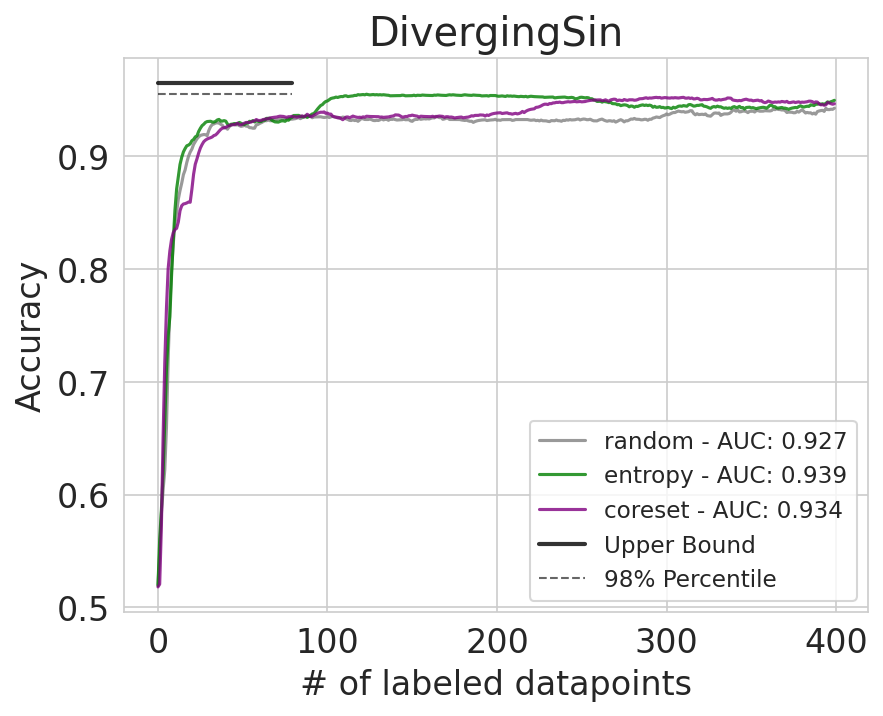

In [20]:
plt.figure(dpi=150)
smoothing = 0.7

# plot_benchmark("DivergingSin/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("DivergingSin/RandomAgent", "grey", display_name="random", smoothing_weight=smoothing)
# plot_benchmark("DivergingSin/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("DivergingSin/ShannonEntropy", "green", display_name="entropy", smoothing_weight=smoothing)
plot_benchmark("DivergingSin/Coreset_Greedy", "purple", display_name="coreset", smoothing_weight=smoothing)
# plot_benchmark("DivergingSin/Badge", "orange", display_name="badge", plot_std=plot_std)
# plot_benchmark("DivergingSin/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_upper_bound('DivergingSin', 80, "black", percentile=0.99)

plt.title('DivergingSin')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# ThreeClust

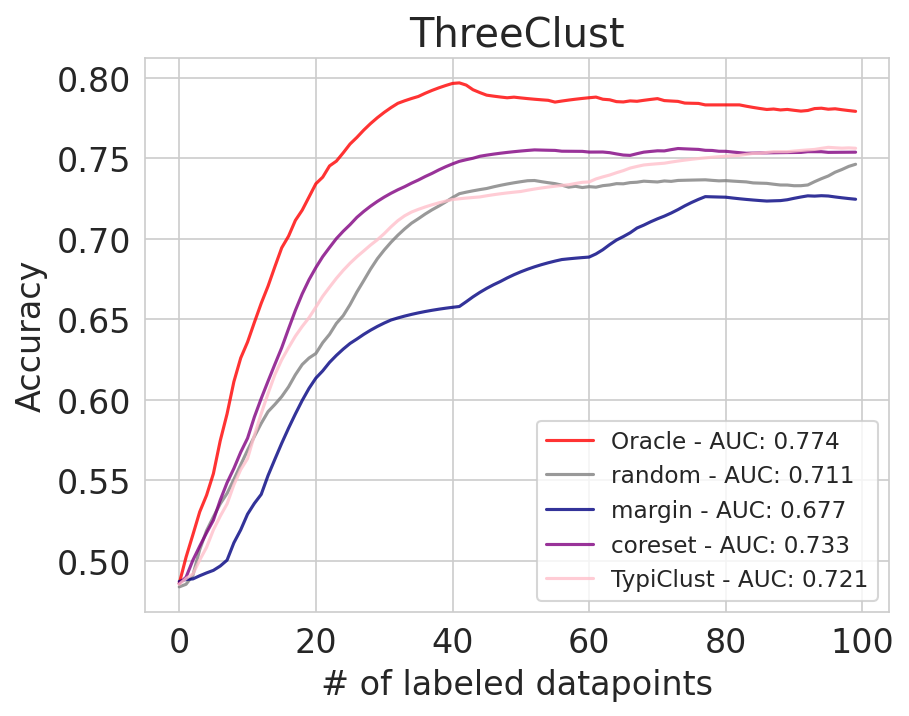

In [21]:
plt.figure(dpi=150)
plot_std = False
smoothing = 0.9

plot_benchmark("ThreeClust/Oracle", "red", display_name="Oracle", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("ThreeClust/RandomAgent", "grey", display_name="random", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("ThreeClust/MarginScore", "navy", display_name="margin", plot_std=plot_std, smoothing_weight=smoothing)
# plot_benchmark("ThreeClust/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("ThreeClust/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std, smoothing_weight=smoothing)
# plot_benchmark("ThreeClust/Badge", "orange", display_name="badge", plot_std=plot_std, smoothing_weight=smoothing)
# plot_benchmark('ThreeClust/SAL_23_01_16', 'orange', display_name='SAL', plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("ThreeClust/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std, smoothing_weight=smoothing)
# plot_upper_bound('Splice', 600, "black", percentile=0.99)

plt.title('ThreeClust')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# Splice

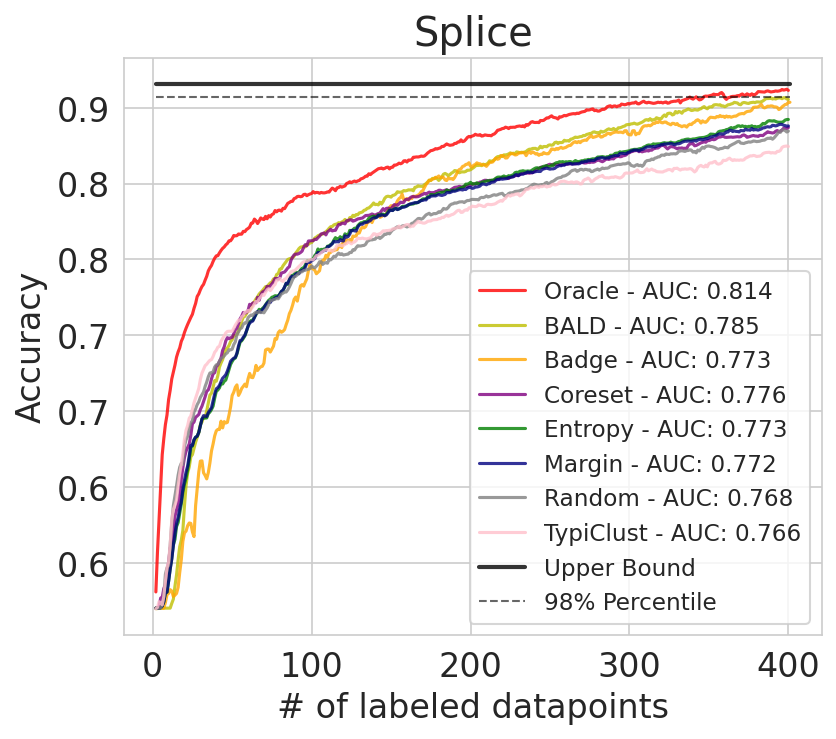

In [22]:
fig = plt.figure(dpi=150, figsize=(6,5))
plot_std = False
smoothing = 0.5

plot_benchmark("Splice/Oracle", "red", display_name="Oracle", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/BALD", "y", display_name="BALD", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/Badge", "orange", display_name="Badge", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/MarginScore", "navy", display_name="Margin", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/RandomAgent", "grey", display_name="Random", plot_std=plot_std, smoothing_weight=smoothing)
plot_benchmark("Splice/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std, smoothing_weight=smoothing)
# plot_benchmark('Splice/SAL_23_01_16', 'orange', display_name='SAL', plot_std=plot_std, smoothing_weight=smoothing)
plot_upper_bound('Splice', 400, "black", percentile=0.99)

plt.title('Splice')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.6, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
fig.axes[0].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.savefig("doc/img/eval_splice.pdf")
plt.show()

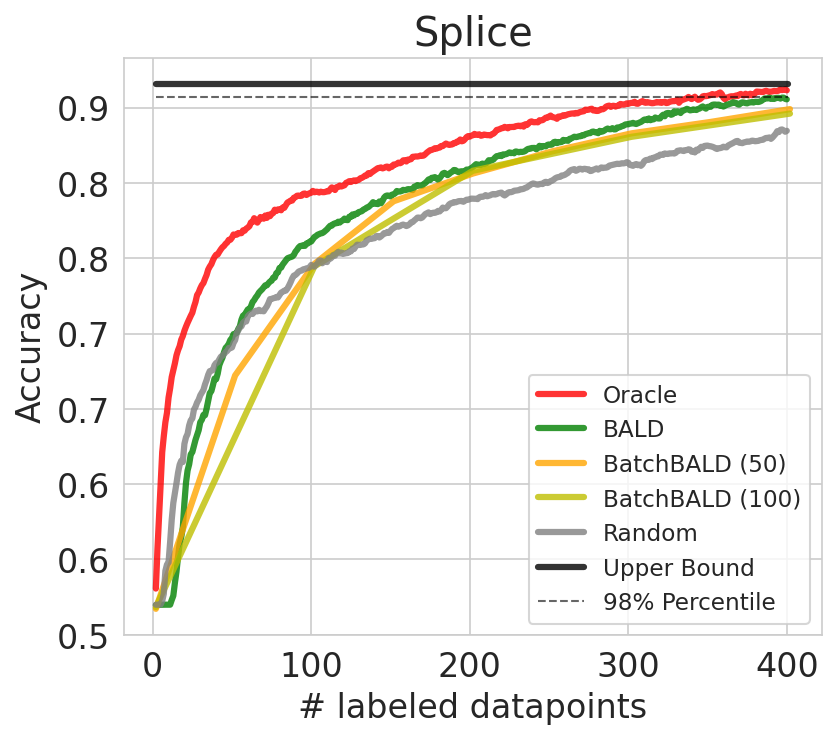

In [23]:
fig = plt.figure(dpi=150, figsize=(6,5))
plot_std = False
smoothing = 0.5
show_auc = False
LW = 3

plot_benchmark("Splice/Oracle", "red", display_name="Oracle", linewidth=LW, show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Splice/BALD", "green", display_name="BALD", linewidth=LW, show_auc=show_auc, smoothing_weight=smoothing)
plot_batch_benchmark("Splice/BatchBALD_50", "orange", linewidth=LW, display_name="BatchBALD (50)", show_auc=show_auc)
plot_batch_benchmark("Splice/BatchBALD_100", "y", linewidth=LW, display_name="BatchBALD (100)", show_auc=show_auc)
plot_benchmark("Splice/RandomAgent", "grey", linewidth=LW, display_name="Random", show_auc=show_auc, smoothing_weight=smoothing)
plot_upper_bound('Splice', 400, "black", linewidth=LW, percentile=0.99)

plt.title('Splice')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.6, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
fig.axes[0].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.savefig("doc/img/ablation_splice_bald.pdf")
plt.show()

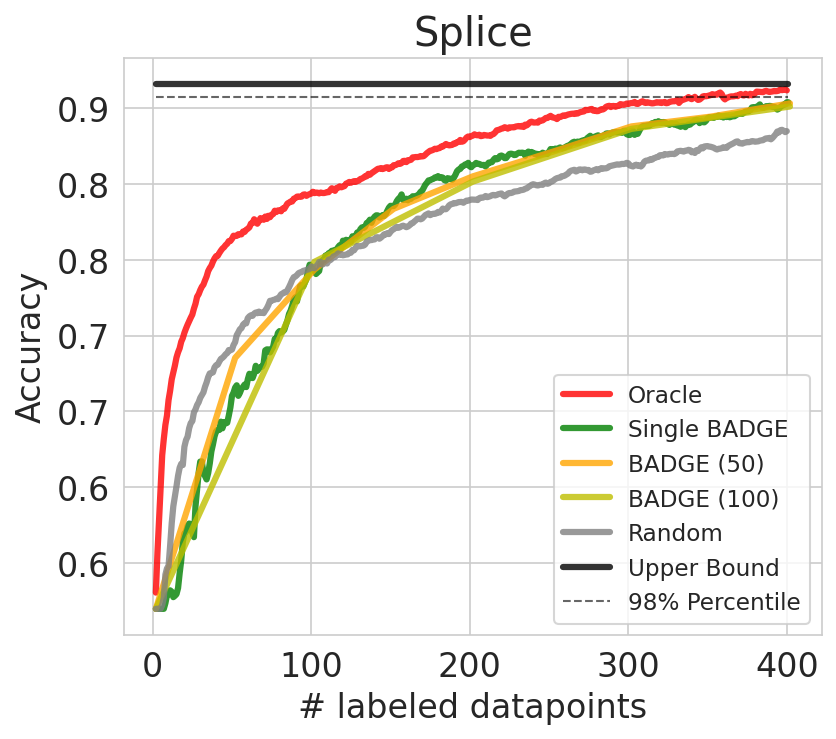

In [24]:
fig = plt.figure(dpi=150, figsize=(6,5))
smoothing = 0.5
show_auc = False
LW = 3

plot_benchmark("Splice/Oracle", "red", display_name="Oracle", linewidth=LW, show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Splice/Badge", "green", display_name="Single BADGE", linewidth=LW, show_auc=show_auc, smoothing_weight=smoothing)
plot_batch_benchmark("Splice/BatchBadge_50", "orange", linewidth=LW, display_name="BADGE (50)", show_auc=show_auc)
plot_batch_benchmark("Splice/BatchBadge_100", "y", linewidth=LW, display_name="BADGE (100)", show_auc=show_auc)
plot_benchmark("Splice/RandomAgent", "grey", linewidth=LW, display_name="Random", show_auc=show_auc, smoothing_weight=smoothing)
plot_upper_bound('Splice', 400, "black", linewidth=LW, percentile=0.99)

plt.title('Splice')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.6, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
fig.axes[0].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.savefig("doc/img/ablation_splice_badge.pdf")
plt.show()

# DNA

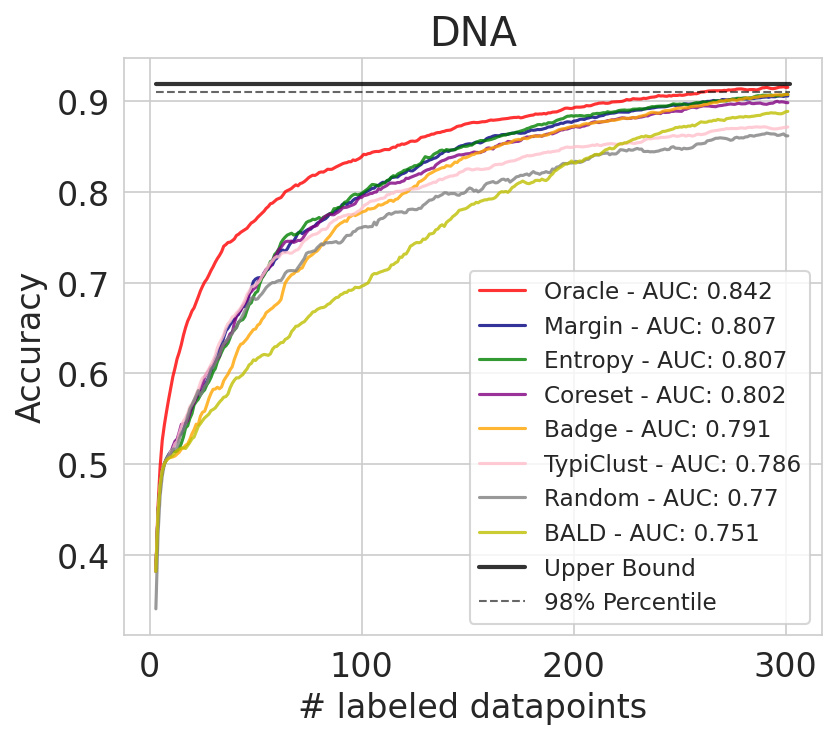

In [25]:
plt.figure(dpi=150, figsize=(6,5))
smoothing = 0.5

plot_benchmark('DNA/Oracle', 'red', display_name='Oracle', smoothing_weight=smoothing)
plot_benchmark("DNA/MarginScore", "navy", display_name="Margin", smoothing_weight=smoothing)
plot_benchmark("DNA/ShannonEntropy", "green", display_name="Entropy", smoothing_weight=smoothing)
plot_benchmark("DNA/Coreset_Greedy", "purple", display_name="Coreset", smoothing_weight=smoothing)
plot_benchmark("DNA/Badge", "orange", display_name="Badge", smoothing_weight=smoothing)
plot_benchmark("DNA/TypiClust", "pink", display_name="TypiClust", smoothing_weight=smoothing)
plot_benchmark("DNA/RandomAgent", "grey", display_name="Random", smoothing_weight=smoothing)
plot_benchmark("DNA/BALD", "y", display_name="BALD", smoothing_weight=smoothing)
plot_upper_bound("DNA", 300, "black", percentile=0.99)

plt.title('DNA')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.5, 0.93)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_dna.pdf")
plt.show()

# USPS

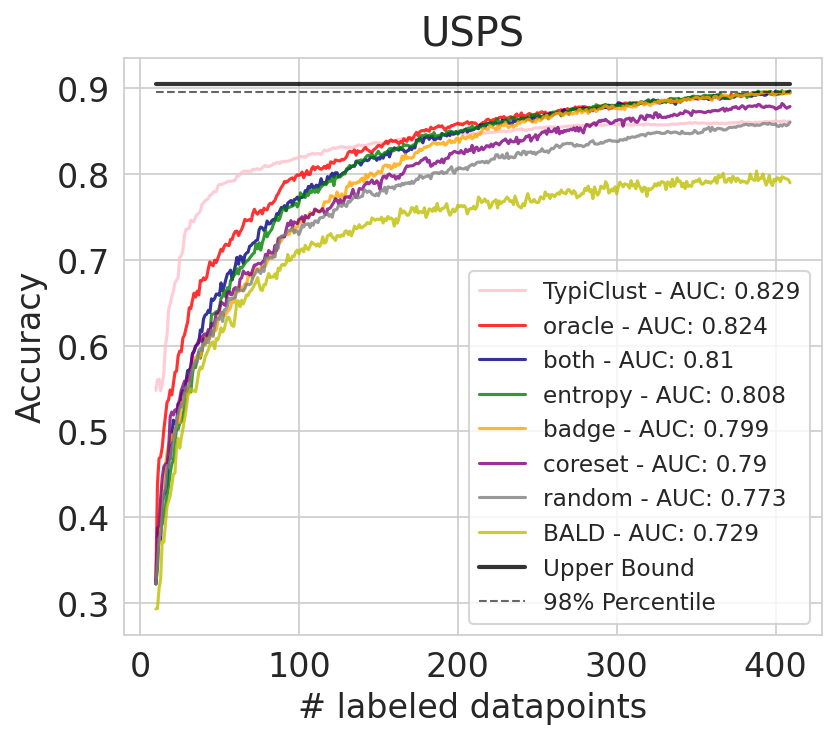

In [26]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("USPS/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark('USPS/Oracle', 'red', display_name='oracle', plot_std=plot_std)
plot_benchmark("USPS/MarginScore", "navy", display_name="both", plot_std=plot_std)
plot_benchmark("USPS/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("USPS/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("USPS/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("USPS/RandomAgent", "grey", display_name="random", plot_std=plot_std)
plot_benchmark("USPS/BALD", "y", display_name="BALD", plot_std=plot_std)
plot_upper_bound("USPS", 400, "black", percentile=0.99)

plt.title('USPS')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.6, 0.93)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_usps.pdf")
plt.show()

# Cifar10 Encoded

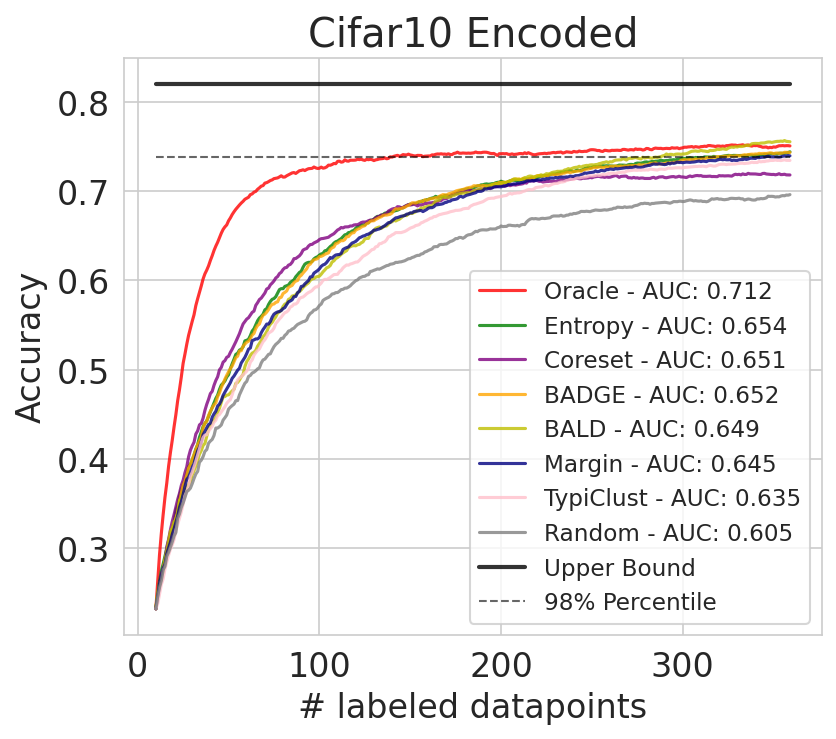

In [27]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("Cifar10Encoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/BALD", "y", display_name="BALD", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/MarginScore", "navy", display_name="Margin", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
# plot_benchmark("Cifar10Encoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("Cifar10Encoded", 350, "black", percentile=0.9)

plt.title('Cifar10 Encoded')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.5, 0.85)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_cifar10_enc.pdf")
plt.show()

# FashionMnist Encoded

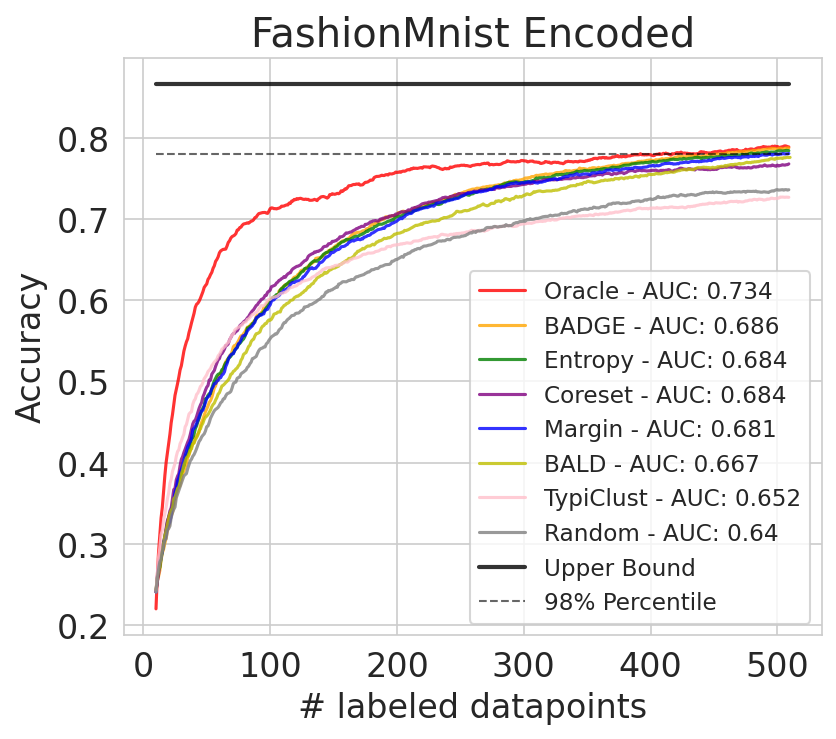

In [28]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("FashionMnistEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/MarginScore", "blue", display_name="Margin", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/BALD", "y", display_name="BALD", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
# plot_benchmark("FashionMnistEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("FashionMnistEncoded", 500, "black", percentile=0.9)

plt.title('FashionMnist Encoded')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.4, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_fmnist_enc.pdf")
plt.show()

# TopV2

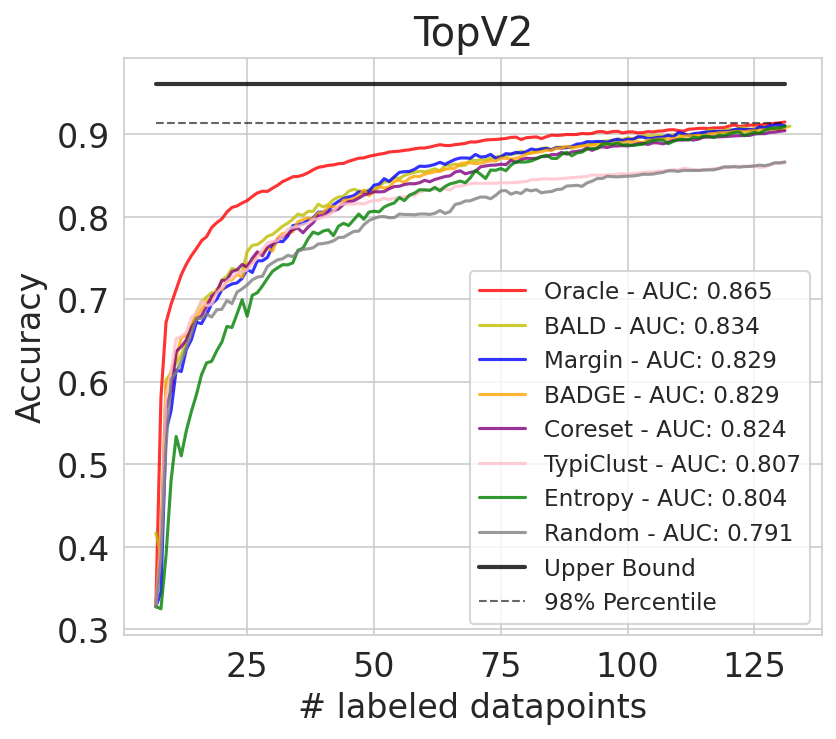

In [29]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("TopV2/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("TopV2/BALD", "y", display_name="BALD", plot_std=plot_std)
plot_benchmark("TopV2/MarginScore", "blue", display_name="Margin", plot_std=plot_std)
plot_benchmark("TopV2/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("TopV2/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("TopV2/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("TopV2/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("TopV2/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
# plot_benchmark("TopV2/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("TopV2", 125, "black", percentile=0.95)

plt.title('TopV2')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.6, 1.0)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_topv2.pdf")
plt.show()

# News

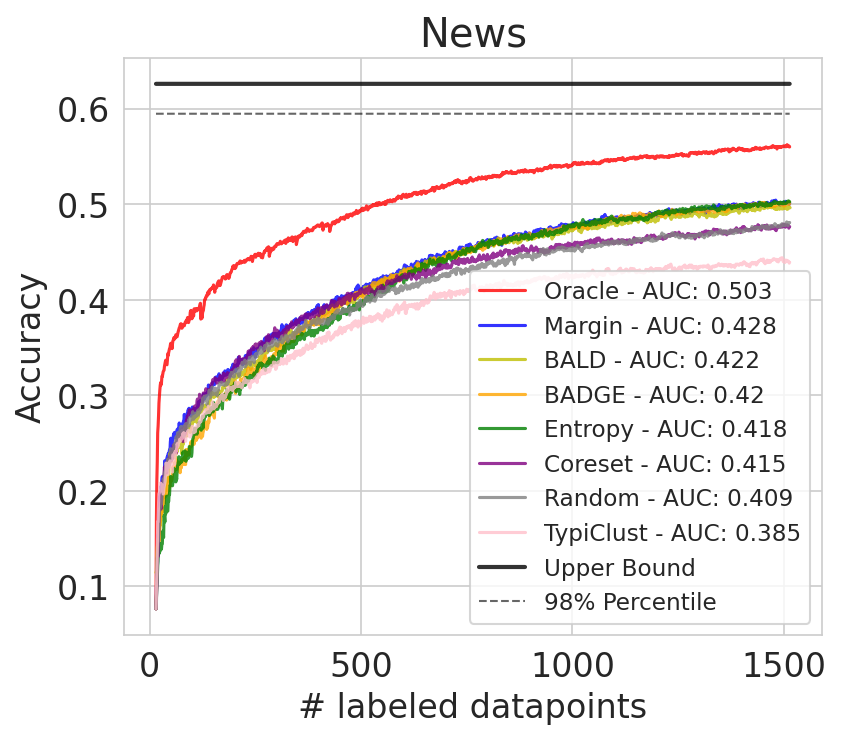

In [30]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("News/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("News/MarginScore", "blue", display_name="Margin", plot_std=plot_std)
plot_benchmark("News/BALD", "y", display_name="BALD", plot_std=plot_std)
plot_benchmark("News/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("News/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("News/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("News/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
plot_benchmark("News/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
# plot_benchmark("News/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("News", 1500, "black", percentile=0.95)

plt.title('News')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.3, 0.65)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_news.pdf")
plt.show()

# Splice Embedded

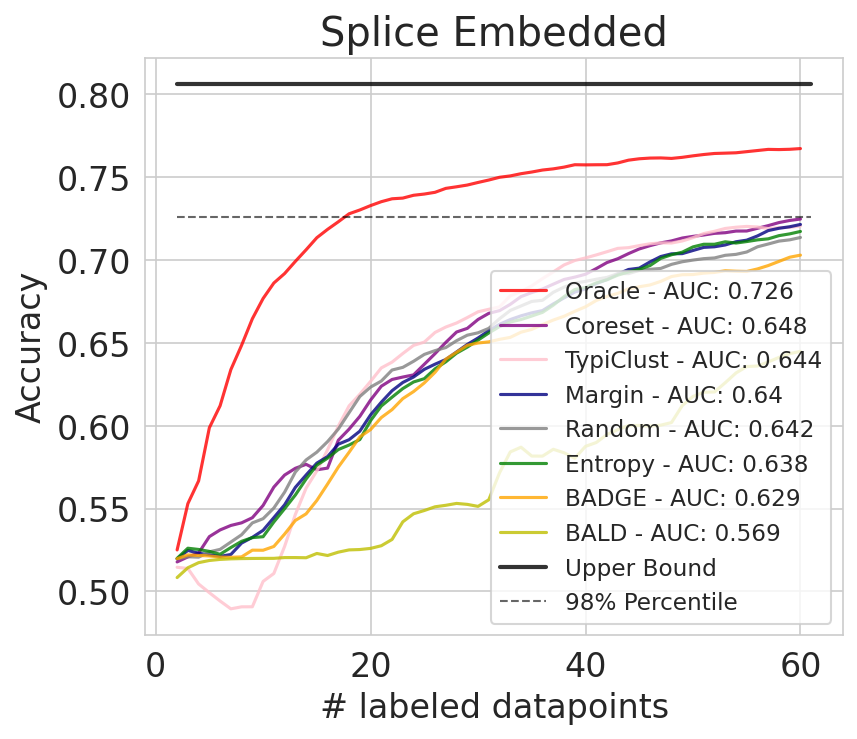

In [31]:
plt.figure(dpi=150, figsize=(6,5))
smoothing = 0.5

plot_benchmark("SpliceEncoded/Oracle", "red", display_name="Oracle", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/Coreset_Greedy", "purple", display_name="Coreset", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/TypiClust", "pink", display_name="TypiClust", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/MarginScore", "navy", display_name="Margin", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/RandomAgent", "grey", display_name="Random", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/ShannonEntropy", "green", display_name="Entropy", smoothing_weight=smoothing)
plot_benchmark("SpliceEncoded/Badge", "orange", display_name="BADGE", smoothing_weight=smoothing)
# plot_benchmark("SpliceEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_benchmark("SpliceEncoded/BALD", "y", display_name="BALD", smoothing_weight=smoothing)
plot_upper_bound('SpliceEncoded', 60, "black", percentile=0.9)

plt.title('Splice Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_splice_enc.pdf")
plt.show()

# DNA Embedded

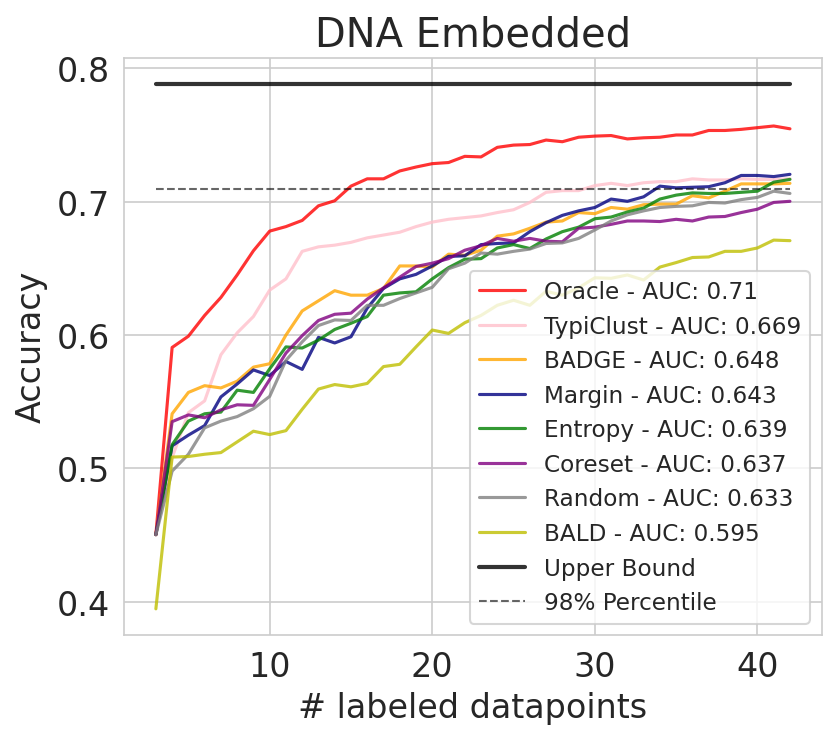

In [32]:
plt.figure(dpi=150, figsize=(6,5))
plot_std = False

plot_benchmark("DNAEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("DNAEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("DNAEncoded/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("DNAEncoded/MarginScore", "navy", display_name="Margin", plot_std=plot_std)
plot_benchmark("DNAEncoded/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("DNAEncoded/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("DNAEncoded/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
plot_benchmark("DNAEncoded/BALD", "y", display_name="BALD", plot_std=plot_std)
# plot_benchmark("DNAEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound('DNAEncoded', 40, "black", percentile=0.9)

plt.title('DNA Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_dna_enc.pdf")
plt.show()

# USPS Embedded

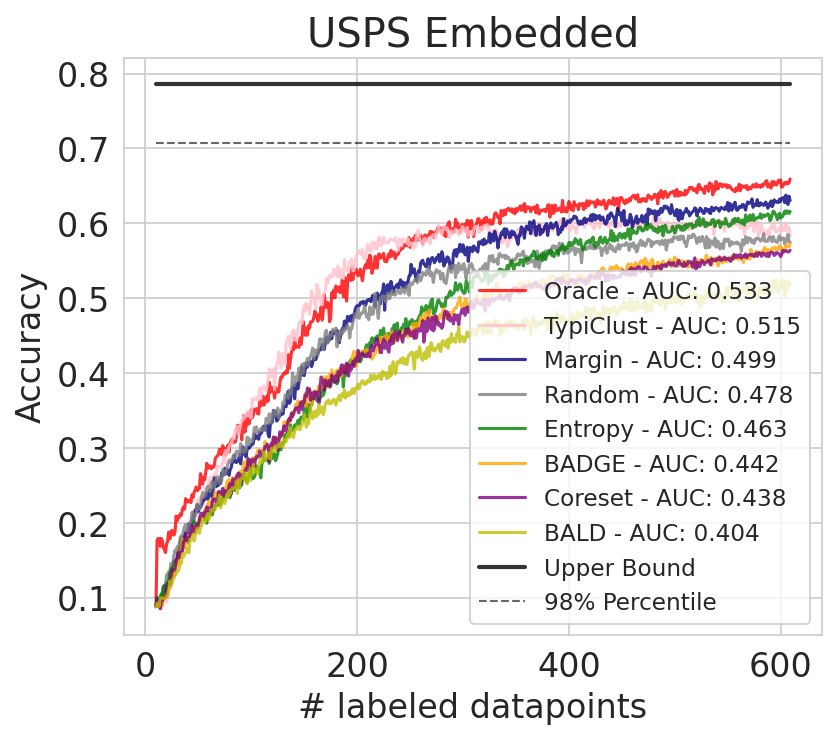

In [33]:
plt.figure(dpi=150, figsize=(6,5))
plot_std = False

plot_benchmark("USPSEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("USPSEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("USPSEncoded/MarginScore", "navy", display_name="Margin", plot_std=plot_std)
plot_benchmark("USPSEncoded/RandomAgent", "grey", display_name="Random", plot_std=plot_std)
plot_benchmark("USPSEncoded/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("USPSEncoded/Badge", "orange", display_name="BADGE", plot_std=plot_std)
plot_benchmark("USPSEncoded/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("USPSEncoded/BALD", "y", display_name="BALD", plot_std=plot_std)
# plot_benchmark("USPSEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound('USPSEncoded', 600, "black", percentile=0.9)

plt.title('USPS Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_usps_enc.pdf")
plt.show()

# MNIST

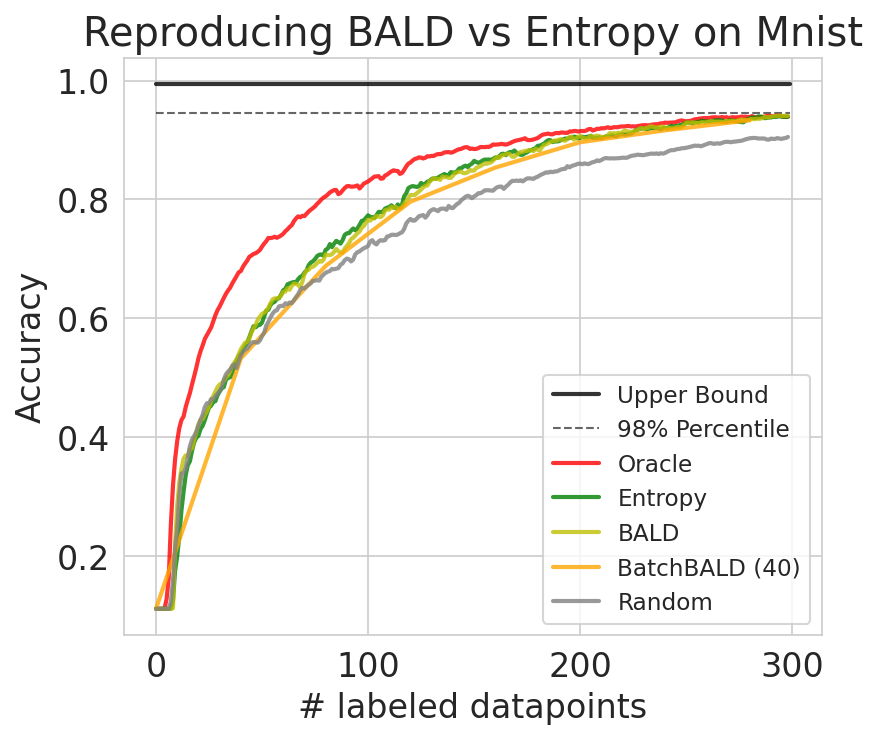

In [34]:
plot_std = False
plt.figure(dpi=150, figsize=(6, 5))
# fontsize
show_auc = False
smoothing = 0.5
linewidth = 2.0

plot_upper_bound("Mnist", 300, "black", percentile=0.95)
plot_benchmark("Mnist/Oracle", "red", display_name="Oracle", show_auc=show_auc, smoothing_weight=smoothing, linewidth=linewidth)
# plot_benchmark("Mnist/MarginScore", "blue", display_name="margin", plot_std=plot_std)
plot_benchmark("Mnist/ShannonEntropy", "green", display_name="Entropy", show_auc=show_auc, smoothing_weight=smoothing, linewidth=linewidth)
plot_benchmark("Mnist/BALD", "y", display_name="BALD", show_auc=show_auc, smoothing_weight=smoothing, linewidth=linewidth)
plot_batch_benchmark("Mnist/BatchBALD", "orange", display_name="BatchBALD (40)", show_auc=show_auc, linewidth=linewidth)
# plot_benchmark("Mnist/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
# plot_benchmark("Mnist/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
# plot_benchmark("Mnist/Badge", "orange", display_name="badge", plot_std=plot_std)
# plot_benchmark("Mnist/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_benchmark("Mnist/RandomAgent", "grey", display_name="Random", show_auc=show_auc, smoothing_weight=smoothing, linewidth=linewidth)

plt.title('Reproducing BALD vs Entropy on Mnist')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.4, 1.0)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/ablation_bald.pdf")
plt.show()

# Cifar10

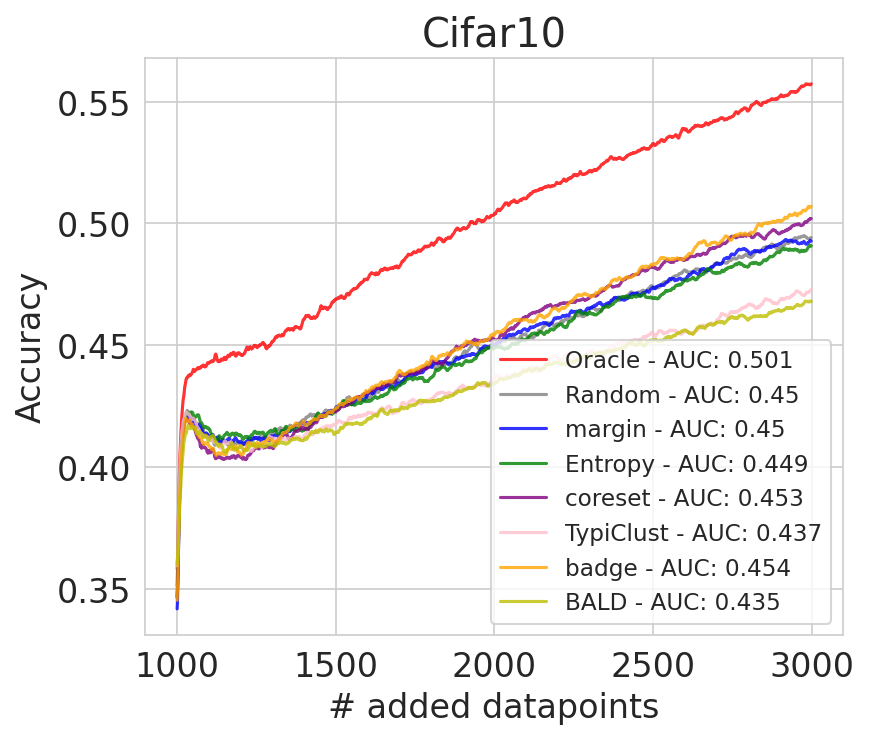

In [35]:
show_auc = True
smoothing = 0.9
plt.figure(dpi=150, figsize=(6,5))

plot_benchmark("Cifar10/Oracle", "red", display_name="Oracle", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/RandomAgent", "grey", display_name="Random", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/MarginScore", "blue", display_name="margin", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/ShannonEntropy", "green", display_name="Entropy", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/Coreset_Greedy", "purple", display_name="coreset", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/TypiClust", "pink", display_name="TypiClust", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/Badge", "orange", display_name="badge", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("Cifar10/BALD", "y", display_name="BALD", show_auc=show_auc, smoothing_weight=smoothing)
# plot_benchmark("Cifar10/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
# plot_upper_bound("Cifar10", 2000, "black")

plt.title('Cifar10')
plt.ylabel('Accuracy')
plt.xlabel('# added datapoints')
# plt.ylim(0.8, 0.95)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_cifar10.pdf")
plt.show()

# FashionMnist

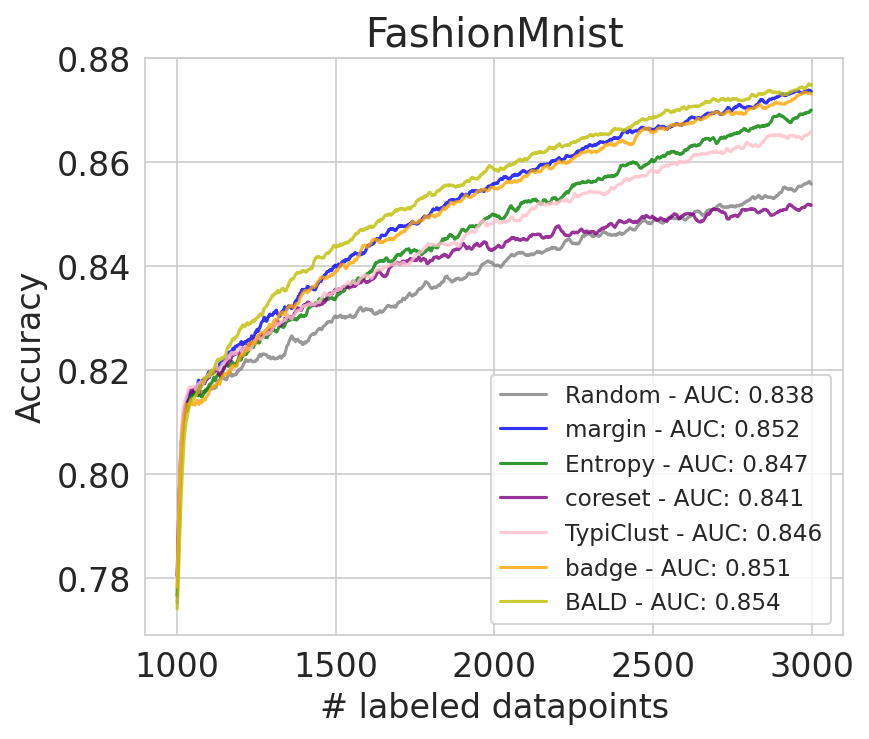

In [36]:
plot_std = False
plt.figure(dpi=150, figsize=(6,5))

# plot_benchmark("FashionMnist/Oracle", "red", display_name="Oracle", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/RandomAgent", "grey", display_name="Random", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/MarginScore", "blue", display_name="margin", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/ShannonEntropy", "green", display_name="Entropy", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/Coreset_Greedy", "purple", display_name="coreset", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/TypiClust", "pink", display_name="TypiClust", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/Badge", "orange", display_name="badge", show_auc=show_auc, smoothing_weight=smoothing)
plot_benchmark("FashionMnist/BALD", "y", display_name="BALD", show_auc=show_auc, smoothing_weight=smoothing)
# plot_upper_bound("FashionMnist", 1000, "black")

plt.title('FashionMnist')
plt.ylabel('Accuracy')
plt.xlabel('# labeled datapoints')
# plt.ylim(0.55, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.savefig("doc/img/eval_fmnist.pdf")
plt.show()